# Quality Prediction in a Mining Process by using RNN

In this tutorial, we will predict how much impurity is in the ore concentrate. As this impurity is measured every hour, if we can predict how much silica (impurity) is in the ore concentrate, we can help the engineers, giving them early information to take actions. Hence, they will be able to take corrective actions in advance (reduce impurity, if it is the case) and also help the environment (reducing the amount of ore that goes to tailings as you reduce silica in the ore concentrate). To this end, we will use the dataset **Quality Prediction in a Mining Process Data** from [Kaggle](https://www.kaggle.com/edumagalhaes/quality-prediction-in-a-mining-process/home). 

We will use [Keras](https://keras.io/), a high-level API for deep learning, which is a wrapper of TensorFlow, CNTK, or Theano. Keras was developed with a focus on enabling fast experimentation, which makes this framework easy to use and learn deep learning.

__All the libraries used in this tutorial are <font color='red'>Open Source</font>__.

In [1]:
# Standard libraries - no deep learning yet
import numpy as np # written in C, is faster and robust library for numerical and matrix operations
import pandas as pd # data manipulation library, it is widely used for data analysis and relies on numpy library.
import matplotlib.pyplot as plt # for plotting
from datetime import datetime # supplies classes for manipulating dates and times in both simple and complex ways

from utils import *

# the following to lines will tell to the python kernel to alway update the kernel for every utils.py
# modification, without the need of restarting the kernel.
# Of course, for every motification in util.py, we need to reload this cell
%load_ext autoreload
%autoreload 2
%matplotlib inline

# If you see some RuntimeWarning, just ignore them.

## Data Processing

**First unzip quality-prediction-in-a-mining-process.zip**

The **Quality Prediction in a Mining Process Data** includes ([Kaggle](https://www.kaggle.com/edumagalhaes/quality-prediction-in-a-mining-process/home)):

 - The first column shows time and date range (from march of 2017 until september of 2017). Some columns were sampled every 20 second. Others were sampled on a hourly base. *This make the data processing harder, however, for this tutorial we will not re-sample the data*.
 - The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant. 
 - Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process. 
 - Column 9 until column 22, we can see process data level and air flow inside the flotation columns, which also impact in ore quality. 
 - The last two columns are the final iron ore pulp quality measurement from the lab. Target is to predict the last column, which is the % of silica in the iron ore concentrate.


We need to use [Pandas](https://pandas.pydata.org/) to perform the data processing. The function  [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) will be used to read the csv file.

In [3]:
dataset = pd.read_csv('flotation_plant.csv',index_col=0,decimal=",")

# Set the index name to 'date'
dataset.index.name = 'date'

# Change all values with NaNs to 0. Instead of just change the NaNs to 0, maybe the best practice is to propagate 
# last valid observation forward to next valid backfill.
dataset.fillna(0, inplace=True)

dataset.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,250.049,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,249.895,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


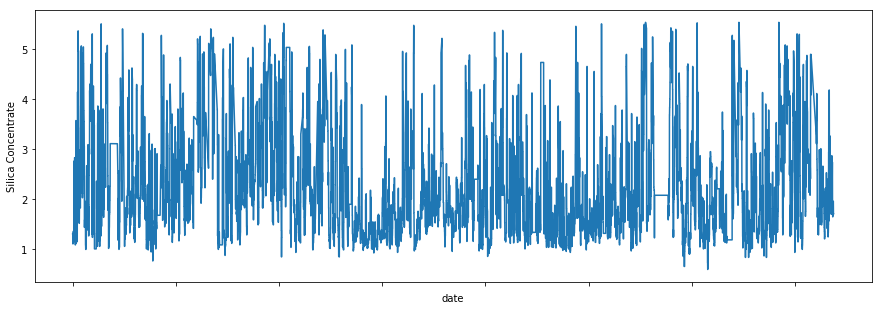

In [4]:
# Ploting the Silica Concentrate
plt.figure(figsize = (15, 5))
plt.xlabel("x")
plt.ylabel("Silica Concentrate")

dataset['% Silica Concentrate'].plot()

### Data Preparation

Here we will normalise all the features and transform the data into a supervised learning problem. The features to be predicted ($t$) are then removed, as we would like to predict just the *Silica Concentrate* (last element in every feature array).


For this task, we will use the library [Scikit-learn](http://scikit-learn.org/stable/), which is a very powerful machine learning library for Python.

In [5]:
# Scikit learn libraries
from sklearn.preprocessing import MinMaxScaler #Allows normalisation

# Convert the data to float
values = dataset.values.astype('float32')

# Normalise features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Specify the number of lag
n_in = 5
n_features = 23

# Transform the time-series to a supervised learning problem representation
reframed = create_window(scaled, n_in = n_in, n_out = 1, drop_nan = True)

# Summarise the new frames (reframes) without removing the wheather data
print(reframed.head(1))

   var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.540799   0.488314   0.479273   0.634233   0.459144   0.639033   

   var7(t-5)  var8(t-5)  var9(t-5)  var10(t-5)    ...     var14(t)  var15(t)  \
5   0.660348   0.371565    0.38877    0.394444    ...     0.355065  0.413945   

   var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  var21(t)  var22(t)  \
5   0.37614  0.439401  0.535974  0.559511  0.511396  0.516164  0.815436   

   var23(t)  
5  0.144016  

[1 rows x 138 columns]


Note that we have 23 outputs (**var1(t)** to **var23(t)**). As we would like to predict just the *Silica Concentrate*, we need to remove the other features. To do so, we will use the function [drop](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html).

## Building the Models

So far, we just created the dataset and showed how we can use pandas for data manipulation. Now, we will preprocess the data and build the following models:
 
 - Simple_RNN
 - GRU
 - LSTM

For [Keras](https://keras.io/), we will using [Tensorflow](https://www.tensorflow.org/) backend by default

In [7]:
# Loading the libraries required for this step.
# keras components, we will describe each one along this tutorial, so don't be worry 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, SimpleRNN, GRU

from math import sqrt

from sklearn.metrics import mean_squared_error # allows compute the mean square error to performance analysis

### Splitting the Data into Train and Test Sets

First, we need to split the dataset into train and test sets.

In [8]:
# split into train and test sets
values = reframed.values

# We will use 80% of the data for training and 20% for testing
n_train = round(0.8 * dataset.shape[0])
train = values[:n_train, :]
test = values[n_train:, :]

# Split into input and outputs
n_obs = n_in * n_features
train_X, train_y = train[:, :n_obs], train[:, n_features-1]
test_X, test_y = test[:, :n_obs], test[:, n_features-1]
print(train_X.shape, len(train_X), train_y.shape)

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_in, n_features))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(589962, 115) 589962 (589962,)
(589962, 5, 23) (589962,) (147486, 5, 23) (147486,)


### Simple (Basic) RNN

Our first model is based on a simple (basic) RNN. This model will consist in a **many_to_one** architecture, in which the input is the **sequence** of the past observations and the output is the predicted value (dimension 1).

In [9]:
# Define the model.
model_rnn = Sequential()

model_rnn.add(SimpleRNN(input_shape=(train_X.shape[1], train_X.shape[2]), 
                        units = 32, 
                        return_sequences = False))
model_rnn.add(Dense(units=1)) 

# We compile the model by defining the mean absolute error (denoted by mae) as loss function and
# adam as optimizer
model_rnn.compile(loss = "mae", 
                  optimizer = "adam")

# just print the model
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1792      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Training
hist_rnn = model_rnn.fit(train_X, train_y, 
                        epochs=100, 
                        batch_size=32, 
                        validation_split = 0.1,
                        verbose=1, shuffle=False) # To not print the output, set verbose=0

Train on 530965 samples, validate on 58997 samples
Epoch 1/100
530965/530965 [==============================] - 46s 87us/step - loss: 0.0386 - val_loss: 0.0519
Epoch 2/100
530965/530965 [==============================] - 46s 86us/step - loss: 0.0199 - val_loss: 0.0536
Epoch 3/100
530965/530965 [==============================] - 50s 94us/step - loss: 0.0165 - val_loss: 0.0672
Epoch 4/100
530965/530965 [==============================] - 47s 89us/step - loss: 0.0152 - val_loss: 0.0435
Epoch 5/100
530965/530965 [==============================] - 46s 86us/step - loss: 0.0137 - val_loss: 0.0447
Epoch 6/100
530965/530965 [==============================] - 46s 86us/step - loss: 0.0128 - val_loss: 0.0288
Epoch 7/100
530965/530965 [==============================] - 46s 86us/step - loss: 0.0125 - val_loss: 0.0417
Epoch 8/100
530965/530965 [==============================] - 46s 86us/step - loss: 0.0119 - val_loss: 0.0277
Epoch 9/100
530965/530965 [==============================] - 46s 86us/step - 

530965/530965 [==============================] - 45s 84us/step - loss: 0.0072 - val_loss: 0.0117
Epoch 76/100
530965/530965 [==============================] - 45s 85us/step - loss: 0.0072 - val_loss: 0.0064
Epoch 77/100
530965/530965 [==============================] - 45s 84us/step - loss: 0.0068 - val_loss: 0.0110
Epoch 78/100
530965/530965 [==============================] - 45s 84us/step - loss: 0.0071 - val_loss: 0.0121
Epoch 79/100
530965/530965 [==============================] - 45s 84us/step - loss: 0.0066 - val_loss: 0.0057
Epoch 80/100
530965/530965 [==============================] - 45s 85us/step - loss: 0.0070 - val_loss: 0.0101
Epoch 81/100
530965/530965 [==============================] - 45s 85us/step - loss: 0.0070 - val_loss: 0.0077
Epoch 82/100
530965/530965 [==============================] - 45s 85us/step - loss: 0.0068 - val_loss: 0.0118
Epoch 83/100
530965/530965 [==============================] - 45s 85us/step - loss: 0.0068 - val_loss: 0.0074
Epoch 84/100
530965/530

#### Using the history 

Here we can see if the model overfits or underfits

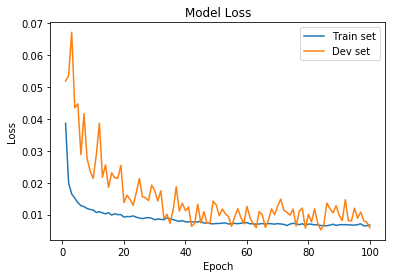

In [11]:
plot_loss(hist_rnn)

#### Prediction and Performance Analysis

In [13]:
yhat_rnn = model_rnn.predict(test_X)

# performing the inverse transform on test_X and yhat_rnn
inv_y_rnn, inv_yhat_rnn = inverse_transform_multiple(test_X, test_y, yhat_rnn, scaler, n_in, n_features)

# calculate MSE
mse_rnn = mean_squared_error(inv_y_rnn, inv_yhat_rnn)
print('Test MSE: %.3f' % mse_rnn)

Test MSE: 0.013


### Visualising the predicted Data

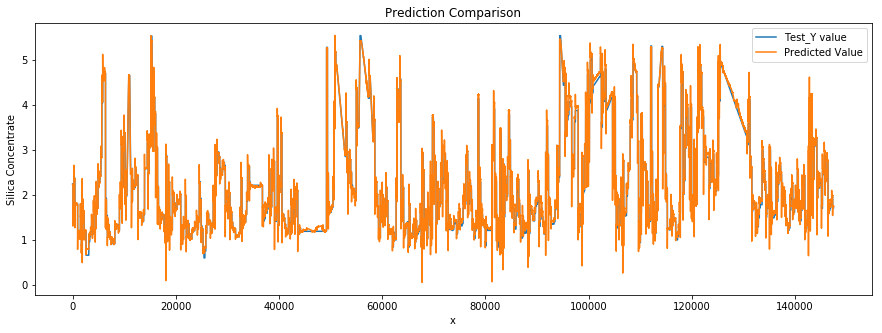

In [14]:
plot_comparison([inv_y_rnn, inv_yhat_rnn],
                ['Test_Y value','Predicted Value'], 
                title='Prediction Comparison')

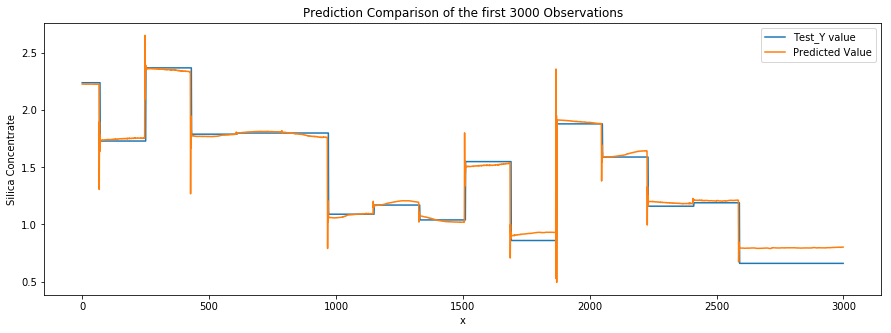

In [15]:
plot_comparison([inv_y_rnn[0:3000], inv_yhat_rnn[0:3000]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison of the first 3000 Observations')

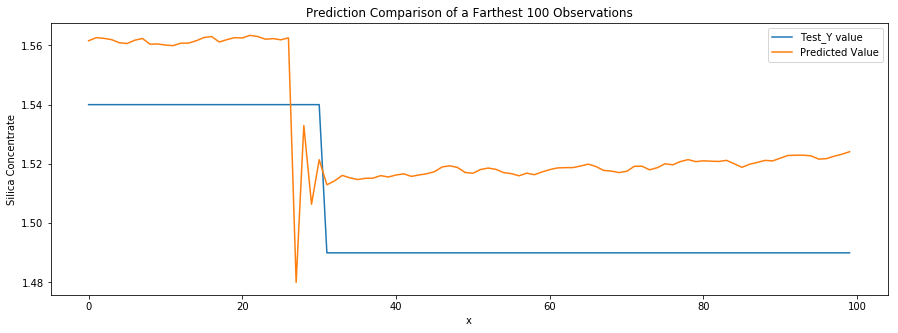

In [16]:
plot_comparison([inv_y_rnn[13000:13100], inv_yhat_rnn[13000:13100]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison of a Farthest 100 Observations')

### GRU

Our second model is based on a GRU. This model will consist in a **many_to_one** architecture, in which the input is the **sequence** of the past observations and the output is the predicted value (dimension 1).

In [17]:
# Define the model.
model_gru = Sequential()

model_gru.add(GRU(input_shape=(train_X.shape[1], train_X.shape[2]), 
                        units = 32, 
                        return_sequences = False))
model_gru.add(Dense(units=1)) 

# We compile the model by defining the mean absolute error (denoted by mae) as loss function and
# adam as optimizer
model_gru.compile(loss = "mae", 
                  optimizer = "adam")

# just print the model
model_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                5376      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Training
hist_gru = model_gru.fit(train_X, train_y, 
                        epochs=100, 
                        batch_size=64, 
                        validation_split = 0.1,
                        verbose=1, shuffle=False) # To not print the output, set verbose=0

Train on 530965 samples, validate on 58997 samples
Epoch 1/100
530965/530965 [==============================] - 48s 89us/step - loss: 0.0327 - val_loss: 0.0313
Epoch 2/100
530965/530965 [==============================] - 46s 86us/step - loss: 0.0114 - val_loss: 0.0145
Epoch 3/100
530965/530965 [==============================] - 46s 87us/step - loss: 0.0097 - val_loss: 0.0105
Epoch 4/100
530965/530965 [==============================] - 46s 87us/step - loss: 0.0084 - val_loss: 0.0236
Epoch 5/100
530965/530965 [==============================] - 45s 85us/step - loss: 0.0087 - val_loss: 0.0173
Epoch 6/100
530965/530965 [==============================] - 46s 87us/step - loss: 0.0082 - val_loss: 0.0185
Epoch 7/100
530965/530965 [==============================] - 46s 86us/step - loss: 0.0074 - val_loss: 0.0127
Epoch 8/100
530965/530965 [==============================] - 47s 89us/step - loss: 0.0066 - val_loss: 0.0096
Epoch 9/100
530965/530965 [==============================] - 48s 90us/step - 

530965/530965 [==============================] - 46s 87us/step - loss: 0.0029 - val_loss: 0.0020
Epoch 76/100
530965/530965 [==============================] - 46s 86us/step - loss: 0.0029 - val_loss: 0.0087
Epoch 77/100
530965/530965 [==============================] - 46s 87us/step - loss: 0.0029 - val_loss: 0.0031
Epoch 78/100
530965/530965 [==============================] - 46s 86us/step - loss: 0.0028 - val_loss: 0.0055
Epoch 79/100
530965/530965 [==============================] - 46s 86us/step - loss: 0.0027 - val_loss: 0.0047
Epoch 80/100
530965/530965 [==============================] - 46s 87us/step - loss: 0.0028 - val_loss: 0.0059
Epoch 81/100
530965/530965 [==============================] - 46s 87us/step - loss: 0.0027 - val_loss: 0.0036
Epoch 82/100
530965/530965 [==============================] - 46s 87us/step - loss: 0.0028 - val_loss: 0.0060
Epoch 83/100
530965/530965 [==============================] - 46s 87us/step - loss: 0.0029 - val_loss: 0.0037
Epoch 84/100
530965/530

#### Using the history 

Here we can see if the model overfits or underfits

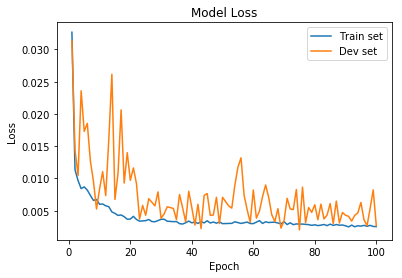

In [33]:
plot_loss(hist_gru)

#### Prediction and Performance Analysis

In [19]:
yhat_gru = model_gru.predict(test_X)

# performing the inverse transform on test_X and yhat_rnn
inv_y_gru, inv_yhat_gru = inverse_transform_multiple(test_X, test_y, yhat_gru, scaler, n_in, n_features)

# calculate RMSE
mse_gru = mean_squared_error(inv_y_gru, inv_yhat_gru)
print('Test MSE: %.3f' % mse_gru)

Test MSE: 0.001


### Visualising the predicted Data

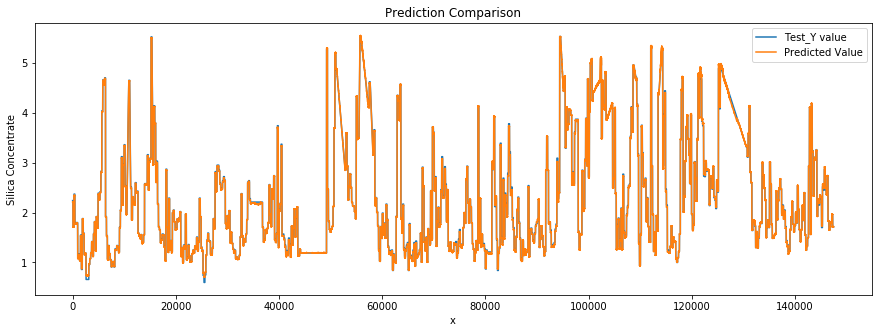

In [20]:
plot_comparison([inv_y_gru, inv_yhat_gru], 
                ['Test_Y value','Predicted Value'], 
                title='Prediction Comparison')

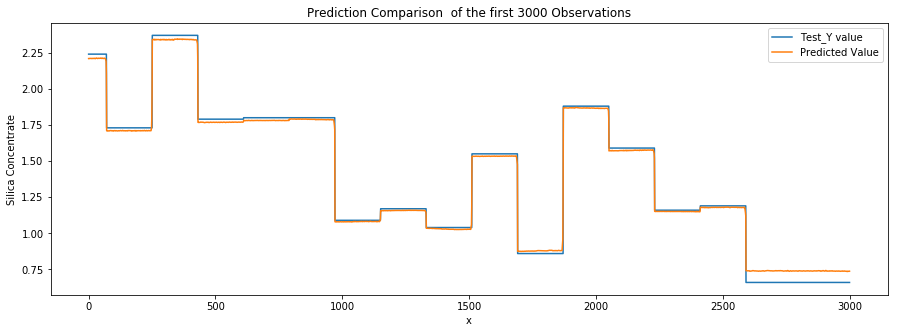

In [21]:
plot_comparison([inv_y_gru[0:3000], inv_yhat_gru[0:3000]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison  of the first 3000 Observations')

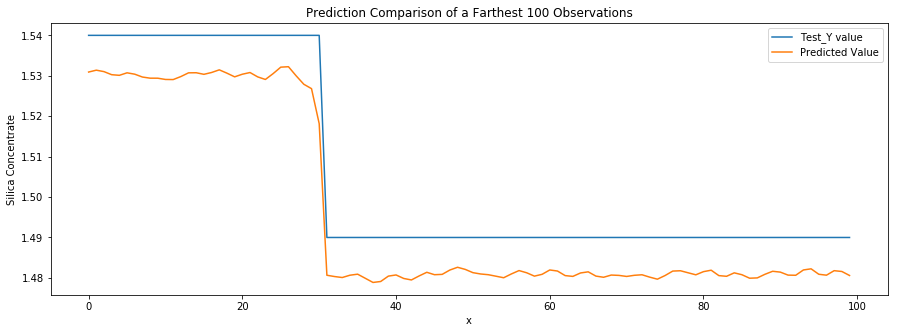

In [22]:
plot_comparison([inv_y_gru[13000:13100], inv_yhat_gru[13000:13100]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison of a Farthest 100 Observations')

### LSTM

Our third model is based on a LSTM. This model will consist in a **many_to_one** architecture, in which the input is the **sequence** of the past observations and the output is the predicted value (dimension 1).

In [23]:
# Define the model.
model_lstm = Sequential()

model_lstm.add(LSTM(input_shape=(train_X.shape[1], train_X.shape[2]), 
                        units = 32, 
                        return_sequences = False))
model_lstm.add(Dense(units=1)) 

# We compile the model by defining the mean absolute error (denoted by mae) as loss function and
# adam as optimizer
model_lstm.compile(loss = "mae", 
                  optimizer = "adam")

# just print the model
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                7168      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 7,201
Trainable params: 7,201
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Training
hist_lstm = model_lstm.fit(train_X, train_y, 
                        epochs=100, 
                        batch_size=32, 
                        validation_split = 0.1,
                        verbose=1, shuffle=False) # To not print the output, set verbose=0

Train on 530965 samples, validate on 58997 samples
Epoch 1/100
530965/530965 [==============================] - 110s 206us/step - loss: 0.0315 - val_loss: 0.0277
Epoch 2/100
530965/530965 [==============================] - 109s 205us/step - loss: 0.0114 - val_loss: 0.0331
Epoch 3/100
530965/530965 [==============================] - 109s 205us/step - loss: 0.0094 - val_loss: 0.0216
Epoch 4/100
530965/530965 [==============================] - 109s 205us/step - loss: 0.0079 - val_loss: 0.0193
Epoch 5/100
530965/530965 [==============================] - 109s 205us/step - loss: 0.0075 - val_loss: 0.0182
Epoch 6/100
530965/530965 [==============================] - 109s 205us/step - loss: 0.0068 - val_loss: 0.0125
Epoch 7/100
530965/530965 [==============================] - 109s 205us/step - loss: 0.0064 - val_loss: 0.0211
Epoch 8/100
530965/530965 [==============================] - 109s 206us/step - loss: 0.0062 - val_loss: 0.0138
Epoch 9/100
530965/530965 [==============================] - 

Epoch 74/100
530965/530965 [==============================] - 109s 206us/step - loss: 0.0029 - val_loss: 0.0065
Epoch 75/100
530965/530965 [==============================] - 109s 205us/step - loss: 0.0026 - val_loss: 0.0052
Epoch 76/100
530965/530965 [==============================] - 109s 205us/step - loss: 0.0025 - val_loss: 0.0047
Epoch 77/100
530965/530965 [==============================] - 109s 206us/step - loss: 0.0029 - val_loss: 0.0046
Epoch 78/100
530965/530965 [==============================] - 109s 206us/step - loss: 0.0028 - val_loss: 0.0065
Epoch 79/100
530965/530965 [==============================] - 109s 206us/step - loss: 0.0029 - val_loss: 0.0048
Epoch 80/100
530965/530965 [==============================] - 109s 206us/step - loss: 0.0029 - val_loss: 0.0074
Epoch 81/100
530965/530965 [==============================] - 109s 206us/step - loss: 0.0028 - val_loss: 0.0072
Epoch 82/100
530965/530965 [==============================] - 109s 206us/step - loss: 0.0026 - val_loss:

#### Using the history 

Here we can see if the model overfits or underfits

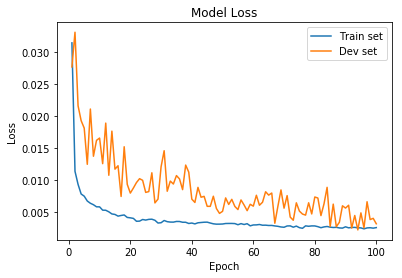

In [25]:
plot_loss(hist_lstm)

#### Prediction and Performance Analysis

In [26]:
yhat_lstm = model_lstm.predict(test_X)

# performing the inverse transform on test_X and yhat_rnn
inv_y_lstm, inv_yhat_lstm = inverse_transform_multiple(test_X, test_y, yhat_lstm, scaler, n_in, n_features)

# calculate RMSE
mse_lstm = mean_squared_error(inv_y_lstm, inv_yhat_lstm)
print('Test MSE: %.3f' % mse_lstm)

Test MSE: 0.003


### Visualising the predicted Data

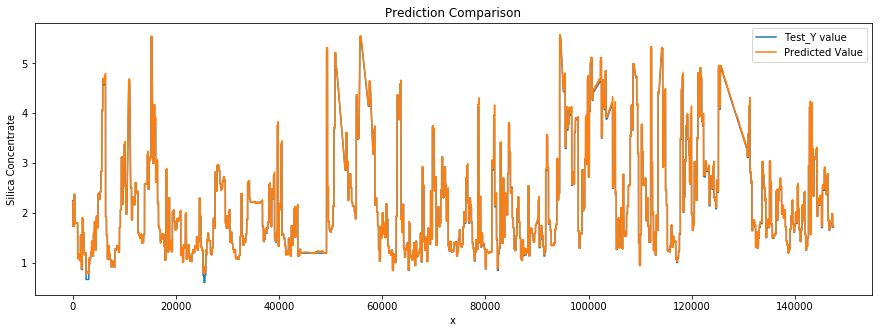

In [27]:
plot_comparison([inv_y_lstm, inv_yhat_lstm], 
                ['Test_Y value','Predicted Value'], 
                title='Prediction Comparison')

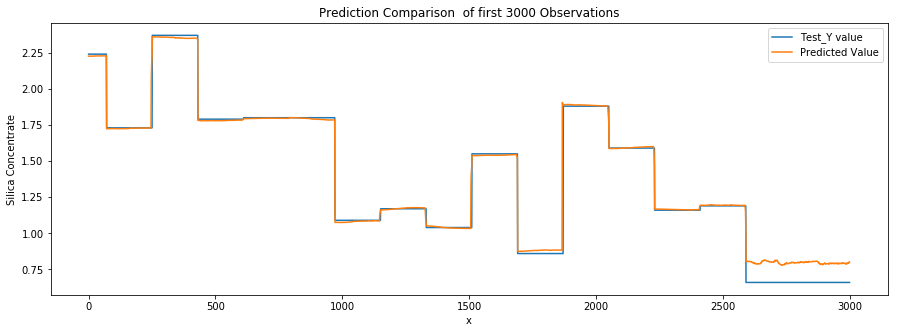

In [28]:
plot_comparison([inv_y_lstm[0:3000], inv_yhat_lstm[0:3000]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison  of first 3000 Observations')

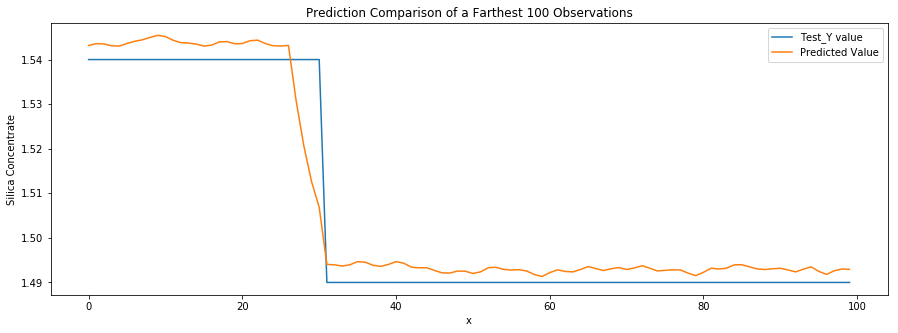

In [29]:
plot_comparison([inv_y_lstm[13000:13100], inv_yhat_lstm[13000:13100]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison of a Farthest 100 Observations')

### Models comparison

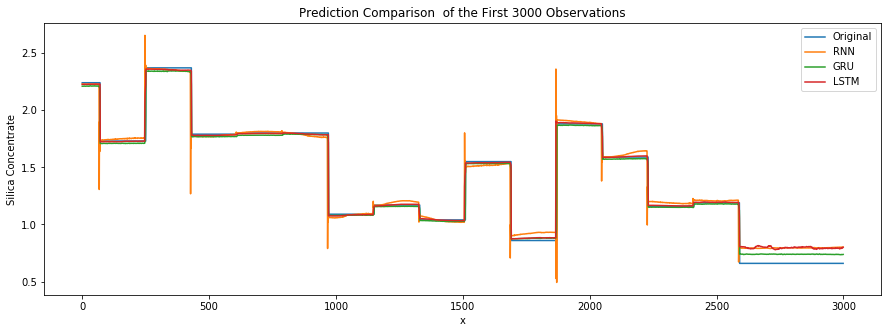

In [30]:
plot_comparison([inv_y_lstm[0:3000], inv_yhat_rnn[0:3000], 
                 inv_yhat_gru[0:3000], inv_yhat_lstm[0:3000]], 
                ['Original', 'RNN', 'GRU', 'LSTM'], 
                title='Prediction Comparison  of the First 3000 Observations')

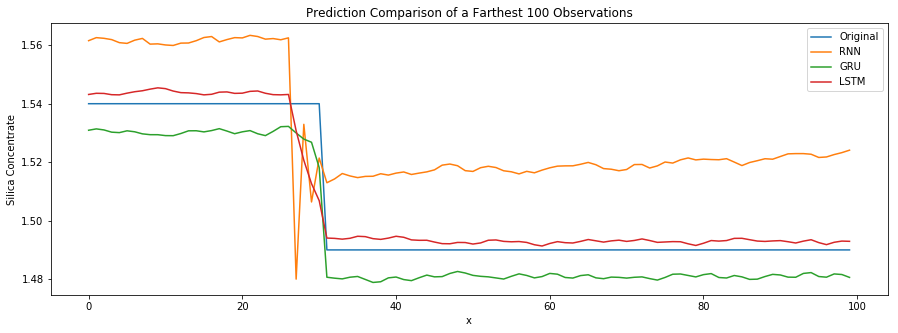

In [31]:
plot_comparison([inv_y_lstm[13000:13100], inv_yhat_rnn[13000:13100], 
                 inv_yhat_gru[13000:13100], inv_yhat_lstm[13000:13100]], 
                ['Original', 'RNN', 'GRU', 'LSTM'], 
                title='Prediction Comparison of a Farthest 100 Observations')

In [32]:
print('Comparing the MSE of the three models:')
print('  Simple RNN: ', mse_rnn)
print('  GRU: ', mse_gru)
print('  LSTM: ', mse_lstm)

Comparing the MSE of the three models:
  Simple RNN:  0.012800533
  GRU:  0.001216877
  LSTM:  0.0029463074
